In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv('data_analyze/training_dataset_3_redundancy.csv')
df.head()

In [3]:
import ast 
import pandas as pd 
# Define target columns with patient_ prefix
target_cols = [
    'patient_any',
    'patient_subdural',
    'patient_epidural',
    'patient_intraparenchymal',
    'patient_intraventricular',
    'patient_subarachnoid'
]

cols = ['any', 'subdural', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid']
df = pd.read_csv('data_analyze/training_dataset_3_redundancy.csv')

# Create target columns
for target, col in zip(target_cols, cols):
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))
    df[target] = df[col].apply(lambda x: 1 if 1 in x else 0)

# Filter and verify columns exist
patient_df = df[target_cols]

# Basic statistics
summary = patient_df.describe()
summary

,patient_any,patient_subdural,patient_epidural,patient_intraparenchymal,patient_intraventricular,patient_subarachnoid
count,21744.000000,21744.000000,21744.000000,21744.000000,21744.000000,21744.000000
mean,0.404249,0.172737,0.015866,0.240664,0.168690,0.175589
std,0.490757,0.378029,0.124962,0.427497,0.374487,0.380479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Count patients with any ICH (at least one positive finding)
ich_patients = (patient_df == 1).any(axis=1).sum()

# Count patients without ICH (all columns zero)
no_ich_patients = (patient_df == 0).all(axis=1).sum()

# Total patients for verification
total_patients = len(patient_df)

# Create result summary
result = pd.DataFrame({
    'Category': ['ICH Cases', 'Non-ICH Cases', 'Total'],
    'Count': [ich_patients, no_ich_patients, total_patients],
    'Percentage': [
        f"{(ich_patients/total_patients)*100:.1f}%",
        f"{(no_ich_patients/total_patients)*100:.1f}%",
        "100%"
    ]
}).set_index('Category')
result

,Count,Percentage
Category,,
ICH Cases,8790,40.4%
Non-ICH Cases,12954,59.6%
Total,21744,100%


In [5]:
# Group by patient_id and check if ANY ICH occurred in their records
ich_status = (df.groupby('patient_id')[target_cols]
    .apply(lambda x: (x == 1).any().any())
    .reset_index(name='has_ich')
)

# Calculate counts
total_patients = ich_status['patient_id'].nunique()
ich_patients = ich_status['has_ich'].sum()
no_ich_patients = total_patients - ich_patients

# Create patient-centric summary
result = pd.DataFrame({
    'Category': ['ICH Patients', 'Non-ICH Patients', 'Total Patients'],
    'Count': [ich_patients, no_ich_patients, total_patients],
    'Percentage': [
        f"{(ich_patients/total_patients)*100:.1f}%",
        f"{(no_ich_patients/total_patients)*100:.1f}%",
        "100%"
    ]
}).set_index('Category')
result

,Count,Percentage
Category,,
ICH Patients,7583,40.0%
Non-ICH Patients,11355,60.0%
Total Patients,18938,100%


In [6]:
# Frequency analysis
frequency = patient_df.apply(pd.Series.value_counts)
frequency

,patient_any,patient_subdural,patient_epidural,patient_intraparenchymal,patient_intraventricular,patient_subarachnoid
0,12954,17988,21399,16511,18076,17926
1,8790,3756,345,5233,3668,3818


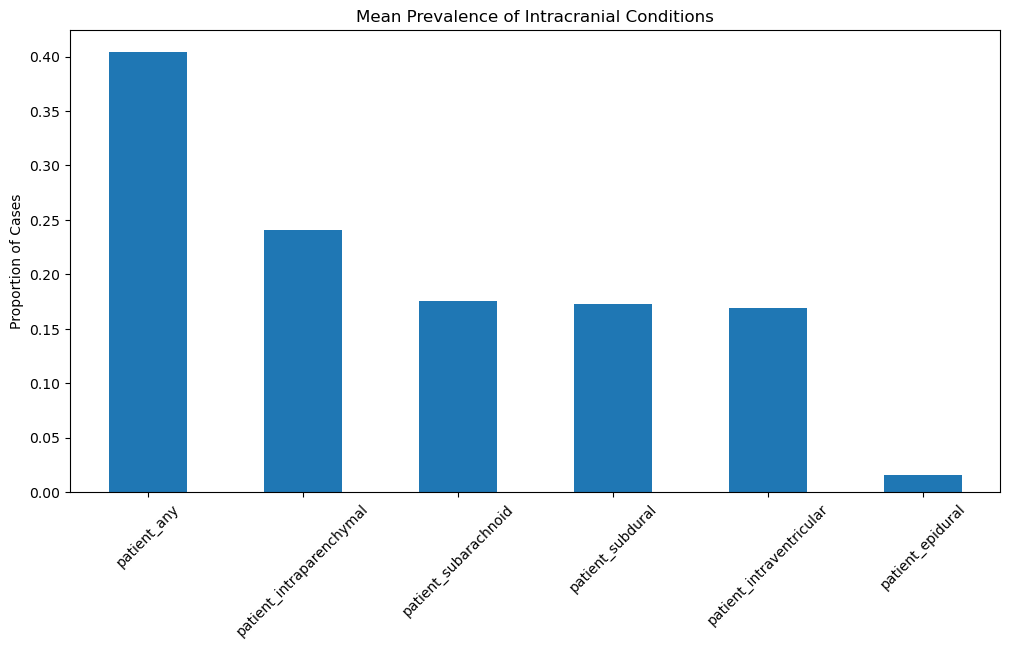

In [7]:
# Visualization
plt.figure(figsize=(12, 6))
patient_df.mean().sort_values(ascending=False).plot(
    kind='bar',
    title='Mean Prevalence of Intracranial Conditions',
    ylabel='Proportion of Cases'
)
plt.xticks(rotation=45)
plt.show()

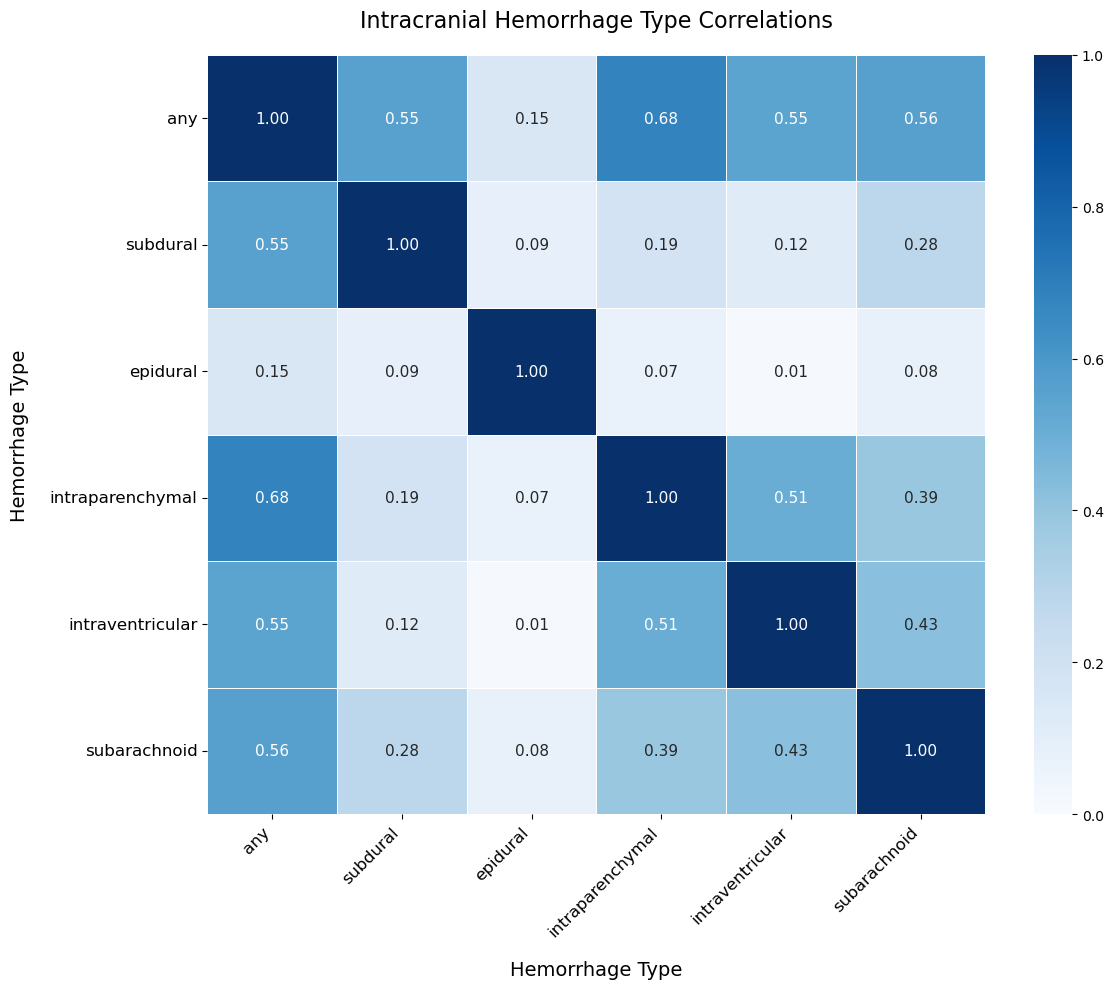

In [8]:
# Create correlation matrix with original columns
corr_matrix = df.filter(regex='^patient_(any|subdural|epidural|intraparenchymal|intraventricular|subarachnoid)').corr()

# Create renamed copy for visualization
plot_labels = [col.replace('patient_', '') for col in corr_matrix.columns]
df_plot = corr_matrix.set_axis(plot_labels, axis=1).set_axis(plot_labels, axis=0)

# Visualize with cleaned labels
plt.figure(figsize=(12,10))
ax = sns.heatmap(
    df_plot,  # Use renamed dataframe
    annot=True,
    cmap='Blues', # Blues, Reds, coolwarm
    vmin=0,
    vmax=1,
    fmt=".2f",
    linewidth=0.5,
    annot_kws={"size": 11}
)

# Enhanced label formatting
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha='right',
    fontsize=12
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=12
)

plt.title("Intracranial Hemorrhage Type Correlations", fontsize=16, pad=20)
plt.xlabel("Hemorrhage Type", fontsize=14, labelpad=15)
plt.ylabel("Hemorrhage Type", fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

TEST_SIZE = 0.15

def split_dataset_for_multilabel(patient_scan_labels, test_size=0.15, val_size=0.25, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels[['patient_any', 'patient_epidural', 'patient_intraparenchymal',
                                  'patient_intraventricular', 'patient_subarachnoid', 'patient_subdural']].values

    if test_size > 0:
        # First split: train + test
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(msss.split(patient_scan_labels, labels))

        train_labels = patient_scan_labels.iloc[train_idx]
        test_labels = patient_scan_labels.iloc[test_idx]

        # Second split: train + validation
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(train_labels, labels[train_idx]))

        train_labels_final = train_labels.iloc[train_idx]
        val_labels = train_labels.iloc[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(patient_scan_labels, labels))

        train_labels_final = patient_scan_labels.iloc[train_idx]
        val_labels = patient_scan_labels.iloc[val_idx]
        test_labels = None

    return train_labels_final, val_labels, test_labels

In [10]:
# import ast
#
# df = pd.read_csv('./data_analyze/training_dataset_1_redundancy.csv')
# # Parsing string columns into lists
# columns_to_parse = ['any', 'subdural', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid']
# for col in columns_to_parse:
#     df[col] = df[col].apply(ast.literal_eval)
#
# # Creating new columns with prefix 'patient_' based on the parsed data
# for col in columns_to_parse:
#     df[f'patient_{col}'] = df[col].apply(lambda x: int(any(x)))
# # Save to csv
# df.to_csv('./data_analyze/training_dataset_2_redundancy.csv', index=False)
#
# # Displaying the updated DataFrame
# df.head(10)

In [11]:
import pandas as pd

patient_scan_labels = pd.read_csv('./data_analyze/training_dataset_3_redundancy.csv')

train_labels, val_labels, test_labels = split_dataset_for_multilabel(patient_scan_labels, test_size=TEST_SIZE)

# Define new columns for hemorrhage types (these should be in your original DataFrame)
hemorrhage_columns = ['patient_any', 'patient_subdural', 'patient_epidural', 'patient_intraparenchymal', 'patient_intraventricular', 'patient_subarachnoid']

def count_hemorrhage_types(data):
    # Original counts for hemorrhage types
    counts = {col: data[col].sum() for col in hemorrhage_columns}
    unique_patients = {col: data[data[col] == 1].shape[0] for col in hemorrhage_columns}

    no_hem_count = (data[hemorrhage_columns].sum(axis=1) == 0).sum()

    counts['No Hemorrhage'] = no_hem_count
    unique_patients['No Hemorrhage'] = no_hem_count

    return counts, unique_patients

# Count for training set
train_counts, train_unique_patients = count_hemorrhage_types(train_labels)

# Count for validation set
val_counts, val_unique_patients = count_hemorrhage_types(val_labels)

# Count for test set
test_counts, test_unique_patients = count_hemorrhage_types(test_labels)

In [27]:
# Update summary data with new category
summary_data = {
    'Hemorrhage Type': hemorrhage_columns + ['No Hemorrhage'],
    'Train Counts': [train_counts[col] for col in hemorrhage_columns] + [train_counts['No Hemorrhage']],
    'Validation Counts': [val_counts[col] for col in hemorrhage_columns] + [val_counts['No Hemorrhage']],
    'Test Counts': [test_counts[col] for col in hemorrhage_columns] + [test_counts['No Hemorrhage']],
    'Total': [train_counts[col] + val_counts[col] + test_counts[col] for col in hemorrhage_columns] + [train_counts['No Hemorrhage'] + val_counts['No Hemorrhage'] + test_counts['No Hemorrhage']]
}

# Create a DataFrame for the summary table
summary_table = pd.DataFrame(summary_data)

# Display the summary table
summary_table

,Hemorrhage Type,Train Counts,Validation Counts,Test Counts,Total
0,patient_any,5662,1888,1332,8882
1,patient_subdural,2456,788,568,3812
2,patient_epidural,226,75,53,354
3,patient_intraparenchymal,3392,1131,798,5321
4,patient_intraventricular,2353,785,554,3692
5,patient_subarachnoid,2506,836,590,3932
6,No Hemorrhage,8199,2733,1930,12862


In [26]:
# First get original counts
original_train_neg = train_counts['No Hemorrhage']
original_train_pos = train_counts['patient_any']

def balance_dataset(train_df, hemorrhage_col='patient_any'):
    """Undersamples negative cases to match positive case count"""
    # Split into positive/negative groups
    pos_cases = train_df[train_df[hemorrhage_col] == 1]
    neg_cases = train_df[train_df[hemorrhage_col] == 0]

    # Undersample negative cases
    neg_cases_sampled = neg_cases.sample(n=len(pos_cases),
                                       random_state=42,
                                       replace=False)

    # Combine and shuffle
    balanced_df = pd.concat([pos_cases, neg_cases_sampled]).sample(frac=1,
                                                                  random_state=42)
    return balanced_df

# Apply undersampling to training set only
balanced_train = balance_dataset(train_labels)

# Verify new counts
new_neg_count = balanced_train[balanced_train['patient_any'] == 0].shape[0]
new_pos_count = balanced_train[balanced_train['patient_any'] == 1].shape[0]

print(f"Original class ratio: {original_train_neg/original_train_pos:.1f}:1")
print(f"New class ratio: {new_neg_count/new_pos_count:.1f}:1")


Original class ratio: 1.5:1
New class ratio: 1.0:1


In [27]:
# Count for training set
train_counts, train_unique_patients = count_hemorrhage_types(balanced_train)

# Count for validation set
val_counts, val_unique_patients = count_hemorrhage_types(val_labels)

# Count for test set
test_counts, test_unique_patients = count_hemorrhage_types(test_labels)

# Update summary data with new category
summary_data = {
    'Hemorrhage Type': hemorrhage_columns + ['No Hemorrhage'],
    'Train Counts': [train_counts[col] for col in hemorrhage_columns] + [train_counts['No Hemorrhage']],
    'Validation Counts': [val_counts[col] for col in hemorrhage_columns] + [val_counts['No Hemorrhage']],
    'Test Counts': [test_counts[col] for col in hemorrhage_columns] + [test_counts['No Hemorrhage']]
}

# Create a DataFrame for the summary table
summary_table = pd.DataFrame(summary_data)

# Display the summary table
summary_table

,Hemorrhage Type,Train Counts,Validation Counts,Test Counts
0,patient_any,5626,1876,1324
1,patient_subdural,2417,803,561
2,patient_epidural,223,74,52
3,patient_intraparenchymal,3350,1117,788
4,patient_intraventricular,2338,779,550
5,patient_subarachnoid,2464,822,580
6,No Hemorrhage,5626,2743,1937


In [28]:
import pandas as pd
import ast

df = pd.read_csv('data_analyze/training_dataset_3.csv')

# Parsing filename column
df['filename'] = df['filename'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Check if any items of filename not start with 'ID_' prefix
invalid_filenames = []
for file_list in df['filename']:
    for filename in file_list:
        if not filename.startswith('ID_'):
            invalid_filenames.append(filename)

print(invalid_filenames)

[]


In [29]:
import pandas as pd
import ast

def update_filenames(df, column_name='filename'):
    def correct_filename(filename):
        if not filename.startswith('ID_'):
            # Remove the 'D_' prefix
            if filename.startswith('D_'):
                return 'ID' + filename[1:]
            else:
                print(f"Invalid filename: {filename}")
        return filename
        # if filename.startswith('ID_D_'):
        #     return filename.replace('ID_D_', 'ID_')
        # return filename

    def process_file_list(file_list):
        return [correct_filename(filename) for filename in file_list]

    # Parse the column if it's a string representation of a list
    df[column_name] = df[column_name].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    # Apply the correction to each filename in the lists
    df[column_name] = df[column_name].apply(process_file_list)

    return df

# Usage
df = pd.read_csv('data_analyze/training_dataset_3.csv')
df = update_filenames(df)

# Verify the changes
invalid_filenames = []
for file_list in df['filename']:
    for filename in file_list:
        try:
            if not filename.startswith('ID_'):
                invalid_filenames.append(filename)
        except:
            print(filename)

print("Invalid filenames after update:", invalid_filenames)

Invalid filenames after update: []


In [30]:
df.to_csv('data_analyze/training_dataset_3.csv', index=False)

# Data Redundancy

In [39]:
# The image position is save in wrong format, we need to fix it
# We need to add the ' to the start and end after the location of first [ and before the last ]

# Fixing the image position column
# Find the first and last index of the '[' character

df = pd.read_csv('data_analyze/training_dataset_4.csv')

# def fix_image_position(image_position_str):
#     first_bracket = image_position_str.index('[')
#     last_bracket = image_position_str.rindex(']')
#     fixed_str = image_position_str[:first_bracket+1] + "'" + image_position_str[first_bracket+1:last_bracket] + "'" + image_position_str[last_bracket:]
#     return fixed_str

# # Apply the function to the image_position column
# df['image_position'] = df['image_position'].apply(fix_image_position)

# Find elements of image_position that not bound by single quotes, update them
# For instance: "'[0, 0, 0]', [0, 1, 1]'" -> "'[0, 0, 0]', '[0, 1, 1]'"

import re

def update_image_position(image_position):
    # Split elements using commas not inside brackets or quotes
    elements = []
    current = []
    in_quotes = False
    bracket_depth = 0
    
    for c in image_position[1:-1]:  # Remove outer brackets
        if c == "'":
            in_quotes = not in_quotes
        elif c == '[' and not in_quotes:
            bracket_depth += 1
        elif c == ']' and not in_quotes:
            bracket_depth -= 1
        
        if c == ',' and not in_quotes and bracket_depth == 0:
            elements.append(''.join(current).strip())
            current = []
        else:
            current.append(c)
    
    if current:
        elements.append(''.join(current).strip())

    # Process elements and add quotes where missing
    processed = []
    for elem in elements:
        elem = elem.strip()
        if not (elem.startswith("'") and elem.endswith("'")):
            # Split multiple lists within single element
            lists = re.findall(r'(\[.*?\])', elem)
            if lists:
                processed.extend([f"'{x}'" for x in lists])
            else:
                processed.append(f"'{elem}'")
        else:
            processed.append(elem)
    
    return f"[{', '.join(processed)}]"

# Test case
image_position = "['[0, 0, 0]', [0, 1, 1], '[1, 1, 1], [2, 2, 2]]"
# result = update_image_position(image_position)
# print(result)  # Outputs: ['[0, 0, 0]', '[0, 1, 1]', '[1, 1, 1]', '[2, 2, 2]']

# Apply the function to the image_position column
# df['image_position'] = df['image_position'].apply(update_image_position)
df['pixel_spacing'] = df['pixel_spacing'].apply(update_image_position)  


# Save the updated DataFrame to a new CSV file
df.to_csv('./data_analyze/training_dataset_4.csv', index=False)

In [8]:
import pandas as pd
import numpy as np
import ast
import re

def parse_image_position(s):
    matches = re.findall(r'\[(-?\d+\.?\d*),\s*(-?\d+\.?\d*),\s*(-?\d+\.?\d*)\]', s)
    return [[float(x), float(y), float(z)] for x, y, z in matches]


# List of columns containing slice-specific data
list_columns = [
    'filename', 'labels', 'any', 'epidural', 'intraparenchymal',
    'intraventricular', 'subarachnoid', 'subdural',
    'samples_per_pixel', 'pixel_spacing', 'pixel_representation',
    'window_center', 'window_width', 'rescale_intercept', 'rescale_slope'
]

# Load and preprocess data
df = pd.read_csv('data_analyze/training_dataset_4.csv')

def process_study(row):
    # Parse lists from string representations
    list_data = {col: ast.literal_eval(row[col]) for col in list_columns}
    positions = parse_image_position(row['image_position'])
    
    # Pair all slice data and sort by Z-coordinate
    slices = list(zip(*[list_data[col] for col in list_columns], positions))
    slices_sorted = sorted(slices, key=lambda x: x[-1][2])
    z_coords = [s[-1][2] for s in slices_sorted]
    
    # Validate slice spacing
    diffs = np.diff(z_coords)
    # if len(diffs) == 0 or not np.allclose(diffs, diffs[0], atol=1):
    #     return []  # Skip non-uniform studies
    
    # Resample to 5mm spacing
    # original_spacing = diffs[0]
    original_spacing = np.mean(diffs)
    target_spacing = 5.0
    step = max(1, int(round(target_spacing / original_spacing)))
    resampled = slices_sorted[::step]
    
    # Keep only up to 28 slices
    resampled = resampled[:28]
    
    # Create a single result
    result = {
        col: [s[idx] for s in resampled] for idx, col in enumerate(list_columns)
    }
    
    return result

# Main processing
new_rows = []
for _, row in df.iterrows():
    processed = process_study(row)
    if processed:
        new_row = row.to_dict()
        for col in list_columns:
            new_row[col] = processed[col]
        new_rows.append(new_row)


processed_df = pd.DataFrame(new_rows)
processed_df.to_csv('data_analyze/training_dataset_3_redundancy.csv', index=False)

# Compare redundancy label

In [33]:
import pandas as pd

df_1 = pd.read_csv('data_analyze/training_dataset_3.csv')
df_2 = pd.read_csv('data_analyze/training_dataset_3_redundancy.csv')

prefix = 'patient_'
postfix = ['any', 'subdural', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid']

# Compare the two DataFrames based on prefix and postfix
for col in postfix:
    col_1 = prefix + col
    col_2 = prefix + col

    # Check if the columns are equal
    if not df_1[col_1].equals(df_2[col_2]):
        print(f"Columns {col_1} and {col_2} are not equal.")